In [260]:
import numpy as np
import random
import os

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

def sampleChania(Chania, n_points, seed_val=0):
    np.random.seed(seed_val)
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

def tf_cov(x):
    mean_x = tf.reduce_mean(x, axis=0, keepdims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx
        
def vandermonde(x):
    vandermonde_x = tf.transpose(tf.stack([tf.ones_like(x[:,0]), 
                                           x[:,0], 
                                           x[:,1], 
                                           tf.square(x[:,0]), 
                                           tf.square(x[:,1]),
                                           tf.multiply(x[:,0], x[:,1])
                                          ]))
    return vandermonde_x

def vandermonde4(x):
    vandermonde4_x = tf.transpose(tf.stack([tf.ones_like(x[:,0]),
                                            x[:,0],
                                            x[:,1],
                                            tf.square(x[:,0]),
                                            tf.square(x[:,1]),
                                            tf.multiply(x[:,0], x[:,1]),
                                            tf.multiply(tf.multiply(x[:,0], x[:,0]), x[:,0]),
                                            tf.multiply(tf.multiply(x[:,1], x[:,1]), x[:,1]),
                                            tf.multiply(tf.square(x[:,0]), x[:,1]),
                                            tf.multiply(tf.square(x[:,1]), x[:,0]),
                                            tf.multiply(tf.square(x[:,0]), tf.square(x[:,0])),
                                            tf.multiply(tf.square(x[:,1]), tf.square(x[:,1])),
                                            tf.multiply(tf.square(x[:,0]), tf.square(x[:,1])),
                                            tf.multiply(tf.square(x[:,0]), tf.multiply(x[:,0], x[:,1])),
                                            tf.multiply(tf.square(x[:,1]), tf.multiply(x[:,1], x[:,0]))
                                           ]))
    return vandermonde4_x

def stats_matrix(x):
    return tf.stack([tf.reduce_mean(x,0), tf.keras.backend.std(x,0)])

Chania = np.genfromtxt('processedChania.csv', delimiter=',')

Chania = Chania[np.where(Chania[:,2]<99)]

In [225]:
def train(trainstep, trainloss, max_iter, session, vis=False):
    plotlist = []
    delta1 = 100
    delta2 = 0
    count_iter = 0
    while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
        count_iter += 1
        delta1 = trainloss.eval(session=session)
        trainstep.run(session=session)
        delta2 = trainloss.eval(session=session)
        plotlist.append(delta2)
        
        
    if vis:
        if abs(delta1-delta2) < 0.0001:
#             print("converged in", count_iter, "steps")
            pass

        else:
            plt.plot(plotlist)
            raise ValueError()
    
    return plotlist

stats before: [[-2.9504299e-08  2.6226044e-08 -3.7550926e-08  8.0466274e-09]
 [ 1.0000000e+00  1.0000001e+00  1.0000001e+00  9.9999976e-01]]
stats_loss: 0.8707684
learned parameters before: [[ 0.8748474 ]
 [-1.8605957 ]
 [ 0.854866  ]
 [-0.56702805]
 [-0.08665323]
 [-0.31604004]]
approx_loss: 1.3382334
stats after: [[-1.333816   1.401888   1.4830753 -0.560755 ]
 [ 0.7210545  0.4877231  1.7336751  0.295697 ]]
stats_loss: 7.6328735
learned parameters after: [[ 5.8110666e-01]
 [ 1.8404627e-01]
 [-1.0374824e+00]
 [-5.4299831e-05]
 [-7.9550743e-02]
 [ 1.7108917e-03]]
approx_loss: 1.3783836
Privatizer converged in 298 steps
Utility Loss: 7.6328735
Adversary Error: 1.4207444



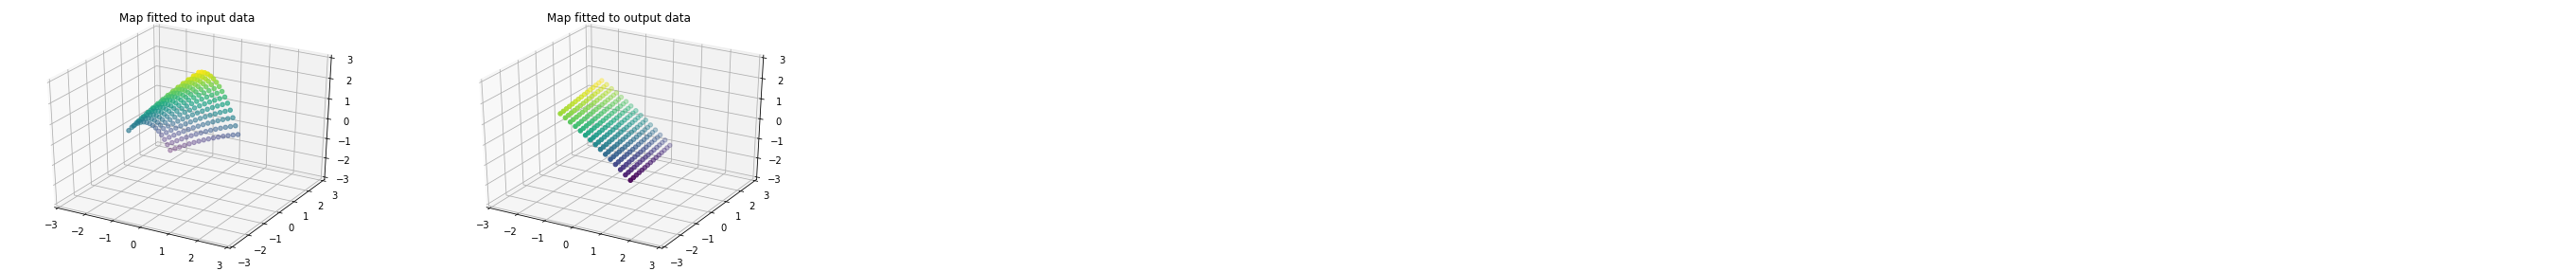

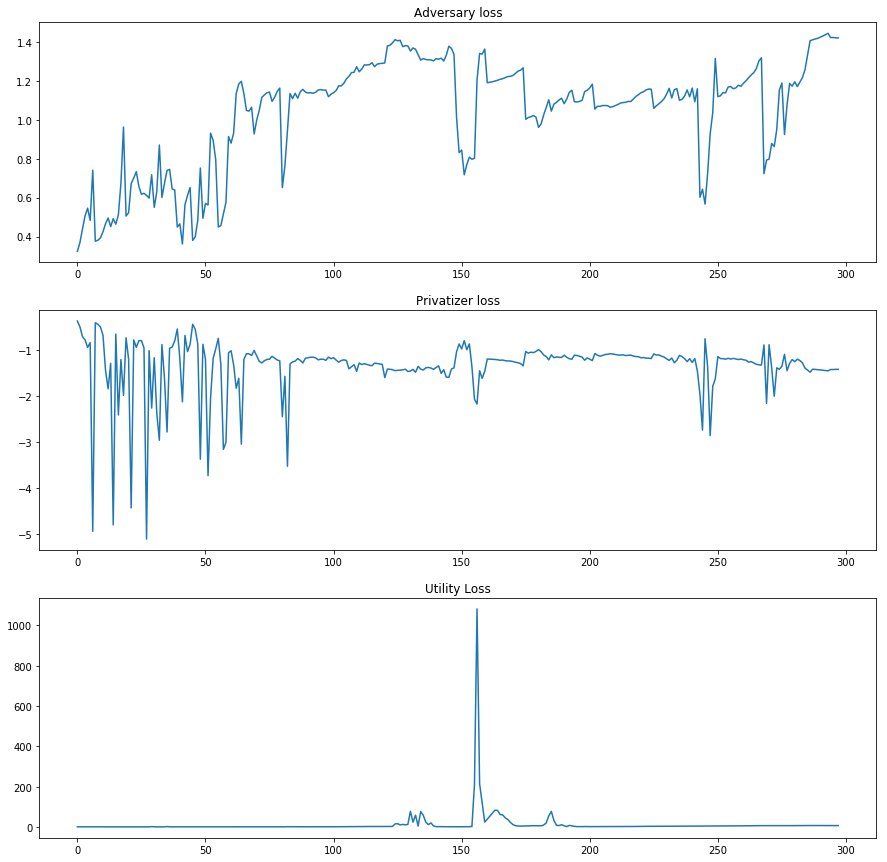

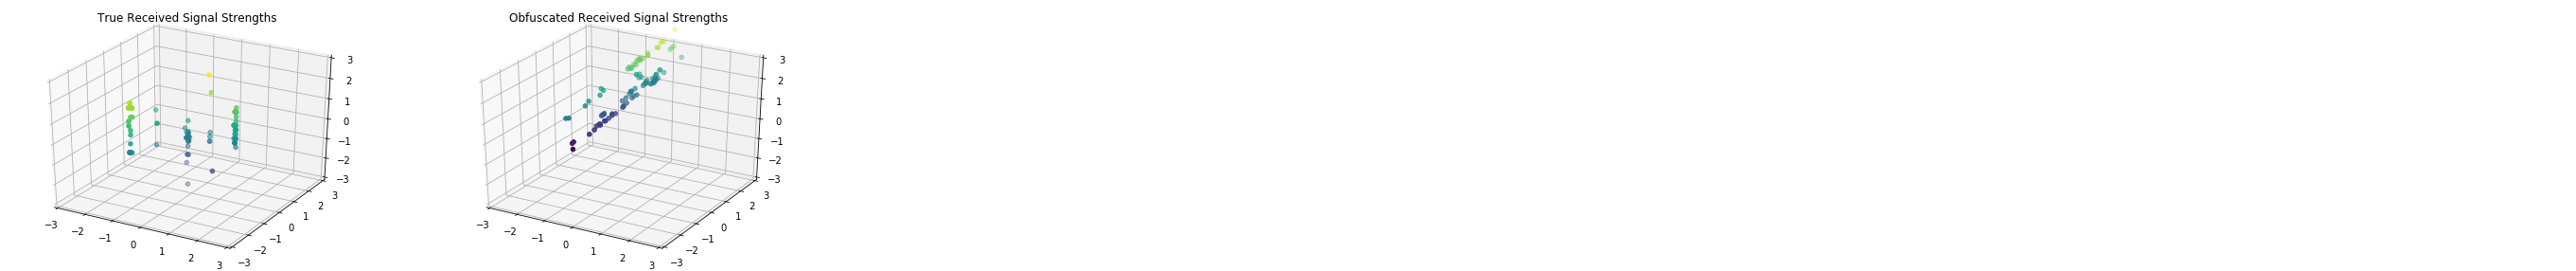

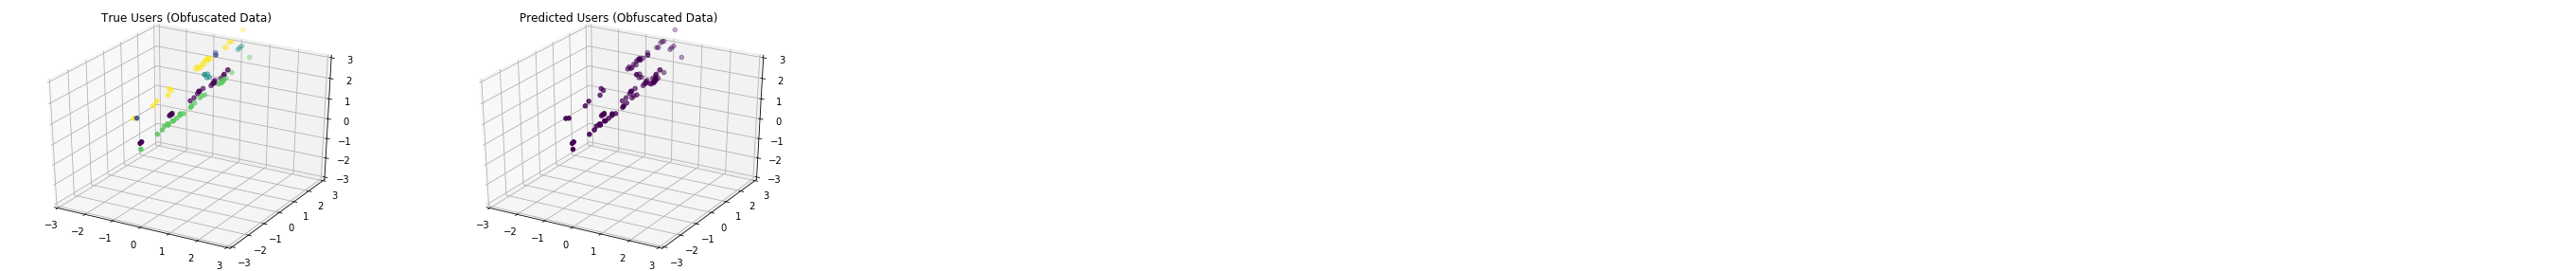

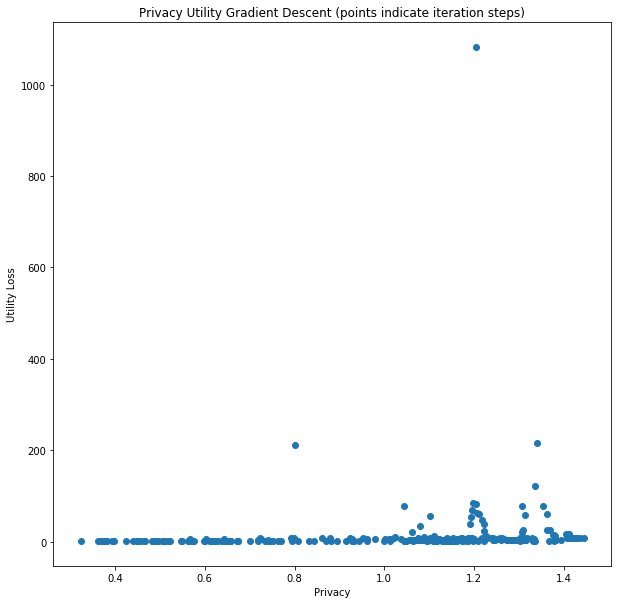

In [267]:
def run_GAP_automation(show=False):
    
    def vis():
    
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], x.eval(session=sess)[:,1], c=x.eval(session=sess)[:,1])
        ax.set_title("True Received Signal Strengths")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=y.eval(session=sess)[:,1])
        ax1.set_title("Obfuscated Received Signal Strengths")
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 3)
        ax1.set_zlim(-3, 3)
        
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=trueusers.eval(session=sess))
        ax.set_title("True Users (Obfuscated Data)")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=np.argmax(users.eval(session=sess), axis=1))
        ax1.set_title("Predicted Users (Obfuscated Data)")
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 3)
        ax1.set_zlim(-3, 3)
        
    def makemap(grid, m1_coeffs, m2_coeffs):
        
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')
        
        vandermonde_grid = vandermonde(grid)

        rss1 = tf.matmul(vandermonde_grid, m1_coeffs)
        ax.scatter(grid.eval(session=sess)[:,1], grid.eval(session=sess)[:,0], rss1.eval(session=sess), c=rss1.eval(session=sess)[:,0])
        ax.set_title("Map fitted to input data")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        rss2 = tf.matmul(vandermonde_grid, m2_coeffs)
        ax1.scatter(grid.eval(session=sess)[:,1], grid.eval(session=sess)[:,0], rss2.eval(session=sess), c=rss2.eval(session=sess)[:,0])
        ax1.set_title("Map fitted to output data")
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 3)
        ax1.set_zlim(-3, 3)
        

    PENALTY = [0]
    I = 1
    all_data = np.empty((I*len(PENALTY),3))

    for P in range(len(PENALTY)):

        for i in range(I):

            sess = tf.Session()
            keras.backend.set_session(sess)
            
            npoints = 100

            x, trueusers = sampleChania(Chania, npoints, seed_val=0)

            # p_init = keras.initializers.RandomNormal(mean=0, stddev=0.6, seed=0)
            p_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=0)
            p1 = keras.layers.Dense(4, kernel_initializer=p_init)
            p2 = keras.layers.Dense(4, kernel_initializer=p_init)
            y = p2(p1(x))
            p_train = tf.train.GradientDescentOptimizer(0.1) # 0.01) # TODO
            p_vars = [p1.variables, p2.variables]

            map1_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            i1 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i2 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i3 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i4 = keras.layers.Dense(1, kernel_initializer=map1_init)
            m1 = i4(i3(i2(i1(x[:,2:]))))
            m1_target = tf.keras.backend.reshape(x[:,1], (npoints,1))
            m1_train = tf.train.GradientDescentOptimizer(0.01)
            m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]
            
            map2_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            o1 = keras.layers.Dense(4, kernel_initializer=map2_init)
            o2 = keras.layers.Dense(4, kernel_initializer=map2_init)
            o3 = keras.layers.Dense(4, kernel_initializer=map2_init)
            o4 = keras.layers.Dense(1, kernel_initializer=map2_init)
            m2 = o4(o3(o2(o1(y[:,2:]))))
            m2_target = tf.keras.backend.reshape(y[:,1], (npoints,1))
            m2_train = tf.train.GradientDescentOptimizer(0.01)
            m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

            a_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=3)
            a1 = keras.layers.Dense(7, kernel_initializer=a_init, activation=tf.nn.relu)
            a2 = keras.layers.Dense(5, kernel_initializer=a_init, activation=tf.nn.softmax)
            users = a2(a1(y))
            a_train = tf.train.GradientDescentOptimizer(0.01) # 0.01)
            a_vars = [a1.variables, a2.variables]

            x1min, x1max = np.min(x[:,2].eval(session=sess)), np.max(x[:,2].eval(session=sess))
            x2min, x2max = np.min(x[:,3].eval(session=sess)), np.max(x[:,3].eval(session=sess))
            testpoints = np.mgrid[x1min:x1max:15j, x2min:x2max:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)
            
            m1_loss = tf.reduce_mean(tf.square(m1_target - m1))
            m2_loss = tf.reduce_mean(tf.square(m2_target - m2))
            adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
            
            zero = tf.constant(0, dtype=tf.float32)
            penalty = tf.constant(PENALTY[P], dtype=tf.float32)
            threshold = tf.constant(0, dtype=tf.float32)     
            
            # UTILITY METRIC - discretized
            target_grid_rss = i4(i3(i2(i1(grid))))
            pred_grid_rss = o4(o3(o2(o1(grid))))
            map_error = tf.reduce_mean(tf.square(target_grid_rss - pred_grid_rss))
            
            # UTILITY METRIC 2 - first order
            stats_loss = tf.reduce_sum(tf.square(stats_matrix(x) - stats_matrix(y)))
            
            # UTILITY METRIC 3 - polynomial regression
            vandermonde_x = vandermonde(x[:,2:])
            m1_coeffs = tf.matmul(tf.linalg.inv(tf.matmul(tf.transpose(vandermonde_x), vandermonde_x)),
                                  tf.matmul(tf.transpose(vandermonde_x), tf.reshape(x[:,1],[100,1])))
            vandermonde_y = vandermonde(y[:,2:])       
            m2_coeffs = tf.matmul(tf.linalg.inv(tf.matmul(tf.transpose(vandermonde_y), vandermonde_y)),
                                  tf.matmul(tf.transpose(vandermonde_y), tf.reshape(y[:,1],[100,1])))
            approx_loss = tf.reduce_mean(tf.square(m2_coeffs - m1_coeffs))
            
            # PRIVATIZER LOSS
            utility_loss = tf.math.maximum(approx_loss, stats_loss)
            privatizer_loss = penalty*(utility_loss)-adversary_loss

            sess.run(tf.global_variables_initializer())
            
            delta1 = 1
            delta2 = 0
            count_iter = 0
            macro_utility_loss = []
            macro_ad_loss = []
            macro_p_loss = []
            max_iter = 1000
            
            print("stats before:", stats_matrix(x).eval(session=sess))
            print("stats_loss:", stats_loss.eval(session=sess))
            print("learned parameters before:", m1_coeffs.eval(session=sess))
            print("approx_loss:", approx_loss.eval(session=sess))
#             m1_train_min = m1_train.minimize(m1_loss, var_list = m1_vars)
#             m1plot = train(m1_train_min, m1_loss, 10000, sess, True)
#             print("generated map error before:", map_error.eval(session=sess))

            while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:

                delta1 = privatizer_loss.eval(session=sess)
                a_train_min = a_train.minimize(adversary_loss, var_list = a_vars)
                aplot = train(a_train_min, adversary_loss, 10000, sess, True)
                macro_ad_loss.append(aplot[-1])
                p_train_min = p_train.minimize(privatizer_loss, var_list = p_vars)
                pplot = train(p_train_min, privatizer_loss, 1, sess)
                macro_p_loss.extend(pplot)
                macro_utility_loss.append(utility_loss.eval(session=sess))
                delta2 = privatizer_loss.eval(session=sess)
                if count_iter%20==0:
                    print(count_iter, delta2)
                count_iter += 1

                
            print("stats after:", stats_matrix(y).eval(session=sess))
            print("stats_loss:", stats_loss.eval(session=sess))
            print("learned parameters after:", m2_coeffs.eval(session=sess))
            print("approx_loss:", approx_loss.eval(session=sess))
#             m2_train_min = m2_train.minimize(m2_loss, var_list = m2_vars)
#             m2plot = train(m2_train_min, m2_loss, 1000, sess, True)
#             print("generated map error after:", map_error.eval(session=sess))
                
            index = int(I*P+i)
                
            if abs(delta1-delta2) < 0.0001:
                print("Privatizer converged in", count_iter, "steps")
                all_data[index] = [PENALTY[P], utility_loss.eval(session=sess), adversary_loss.eval(session=sess)]

                
            else:
                print("Privatizer did not converge")
                # all_data[index] = [PENALTY[P], utility_loss.eval(session=sess), adversary_loss.eval(session=sess)]
                all_data[index] = [PENALTY[P], np.nan, np.nan]

            print("Utility Loss:", utility_loss.eval(session=sess))
            print("Adversary Error:", adversary_loss.eval(session=sess))
            print("")
            
            tf.keras.backend.clear_session()
            
            makemap(grid, m1_coeffs, m2_coeffs)
        
            if show:
                
                fig, ax = plt.subplots(3,1, figsize=(15,15))
                fig.subplots_adjust(hspace=0.2)
                ax[0].plot(macro_ad_loss)
                ax[0].set_title("Adversary loss")
                ax[1].plot(macro_p_loss)
                ax[1].set_title("Privatizer loss")
                ax[2].plot(macro_utility_loss)
                ax[2].set_title("Utility Loss")
                vis()
                
                # show at each iteration which point on the privacy utility trade we're at
                fig, ax_ = plt.subplots(1,1, figsize=(10,10))
                ax_.scatter(macro_ad_loss, macro_utility_loss)
                ax_.set_xlabel("Privacy")
                ax_.set_ylabel("Utility Loss")
                ax_.set_title("Privacy Utility Gradient Descent (points indicate iteration steps)")
    
    return all_data

gap_data = run_GAP_automation(show=True)

In [254]:
tf.keras.backend.clear_session()

In [268]:
gap_data

array([[0.        , 7.63287354, 1.42074442]])

In [269]:
GAP_data = gap_data
# GAP_data = np.append(GAP_data, gap_data[:-1], axis=0)

In [270]:
GAP_data

array([[0.        , 7.63287354, 1.42074442]])

In [271]:
# GAP_data = GAP_data[np.where(GAP_data[:,0]!=0)]

Text(0.5, 1.0, 'Privacy Utility Trade: GAP Privatizer, Worst Case Adversary')

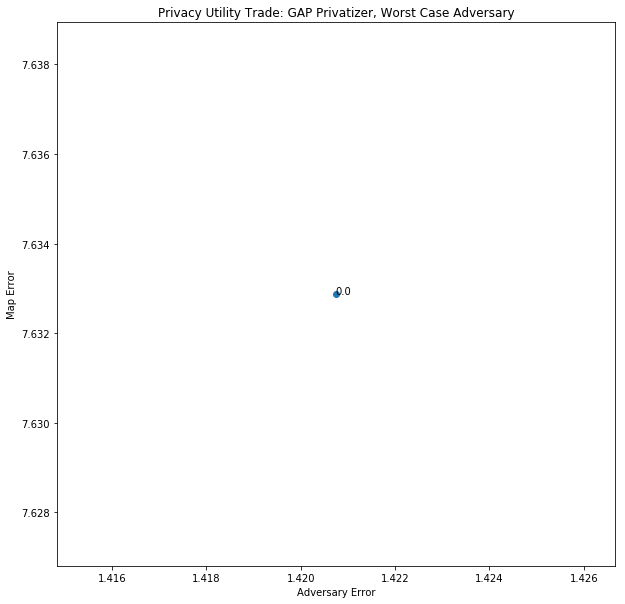

In [272]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(GAP_data[:,0]):
    indices = np.where(GAP_data[:,0]==i)
    plt.scatter(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]))
    plt.text(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]), str(GAP_data[indices][0][0]))
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: GAP Privatizer, Worst Case Adversary")

stats before: [[-2.9504299e-08  2.6226044e-08 -3.7550926e-08  8.0466274e-09]
 [ 1.0000000e+00  1.0000001e+00  1.0000001e+00  9.9999976e-01]]
stats_loss: 0.000914033
learned parameters before: [[ 0.8748474 ]
 [-1.8605957 ]
 [ 0.854866  ]
 [-0.56702805]
 [-0.08665323]
 [-0.31604004]]
approx_loss: 0.87573713
stats after: [[ 1.0738725e-02 -5.5486439e-03  9.7827252e-04  8.0563063e-03]
 [ 1.0179552e+00  1.0025038e+00  9.8467344e-01  1.0117683e+00]]
stats_loss: 0.000914033
learned parameters after: [[-0.3067512 ]
 [-0.29686737]
 [ 0.18766212]
 [-0.23296356]
 [ 0.1024065 ]
 [ 0.5897732 ]]
approx_loss: 0.87573713
Utility Loss: 0.87573713
Adversary Error: 0.24946235

stats before: [[-2.9504299e-08  2.6226044e-08 -3.7550926e-08  8.0466274e-09]
 [ 1.0000000e+00  1.0000001e+00  1.0000001e+00  9.9999976e-01]]
stats_loss: 0.0047352817
learned parameters before: [[ 0.8748474 ]
 [-1.8605957 ]
 [ 0.854866  ]
 [-0.56702805]
 [-0.08665323]
 [-0.31604004]]
approx_loss: 0.89131385
stats after: [[ 0.02147744

/home/lilly/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


stats before: [[-2.9504299e-08  2.6226044e-08 -3.7550926e-08  8.0466274e-09]
 [ 1.0000000e+00  1.0000001e+00  1.0000001e+00  9.9999976e-01]]
stats_loss: 0.37190068
learned parameters before: [[ 0.8748474 ]
 [-1.8605957 ]
 [ 0.854866  ]
 [-0.56702805]
 [-0.08665323]
 [-0.31604004]]
approx_loss: 1.0341209
stats after: [[ 0.08590977 -0.04438928  0.00782622  0.06445047]
 [ 1.3564113   1.2953691   1.1517848   1.347885  ]]
stats_loss: 0.37190068
learned parameters after: [[-0.29968858]
 [ 0.01214953]
 [-0.01589667]
 [-0.04880324]
 [ 0.09400459]
 [ 0.19248122]]
approx_loss: 1.0341209
Utility Loss: 1.0341209
Adversary Error: 0.6402331

stats before: [[-2.9504299e-08  2.6226044e-08 -3.7550926e-08  8.0466274e-09]
 [ 1.0000000e+00  1.0000001e+00  1.0000001e+00  9.9999976e-01]]
stats_loss: 0.5529444
learned parameters before: [[ 0.8748474 ]
 [-1.8605957 ]
 [ 0.854866  ]
 [-0.56702805]
 [-0.08665323]
 [-0.31604004]]
approx_loss: 1.0494593
stats after: [[ 0.09664848 -0.04993793  0.00880449  0.072506

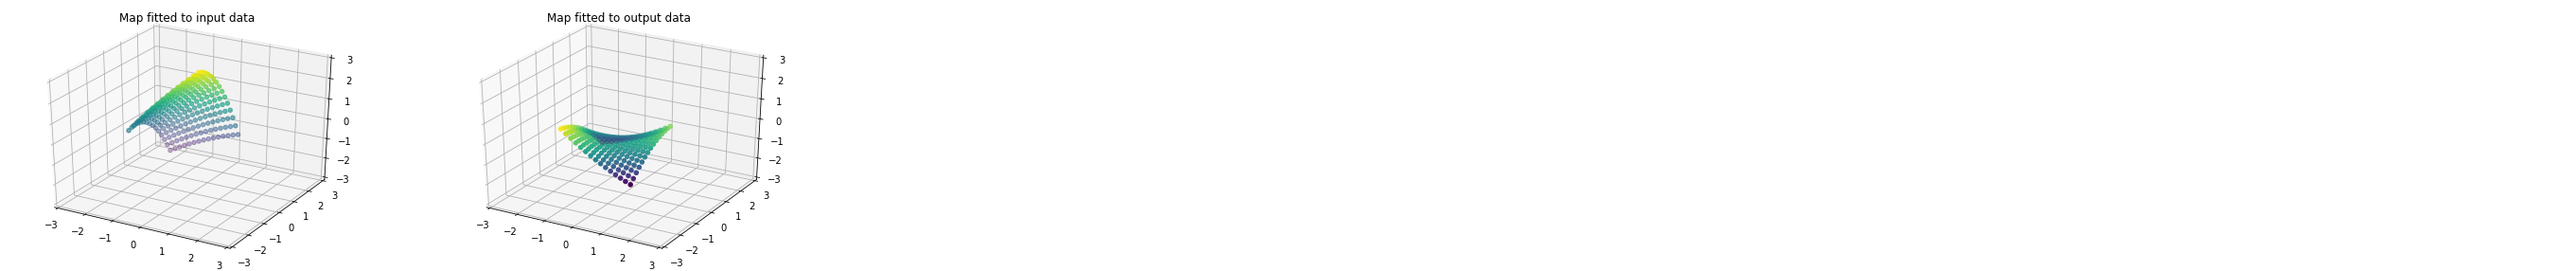

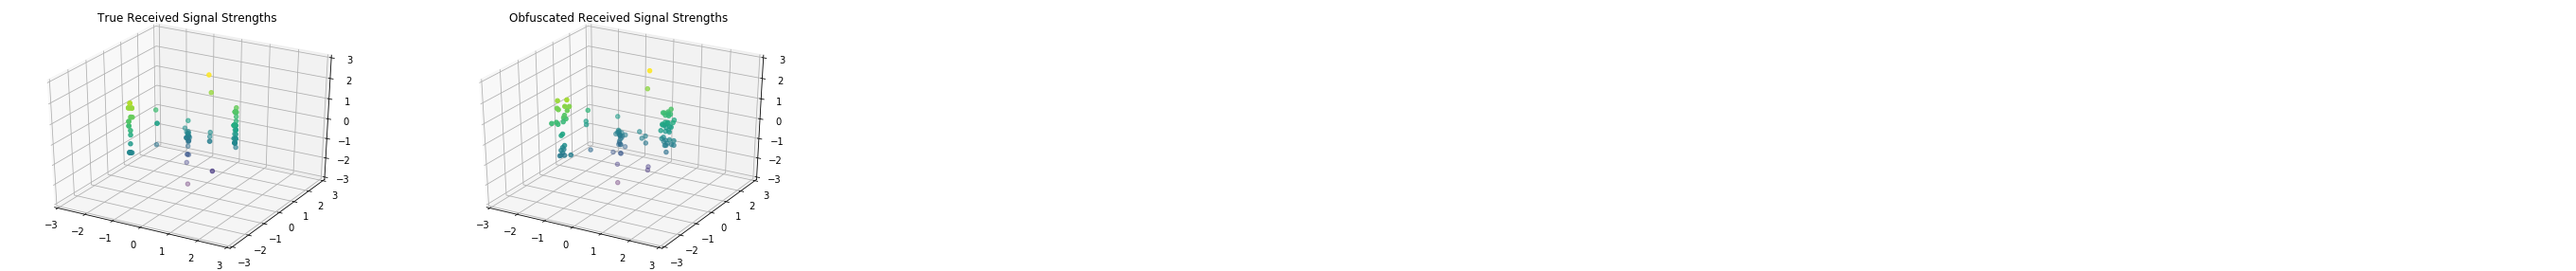

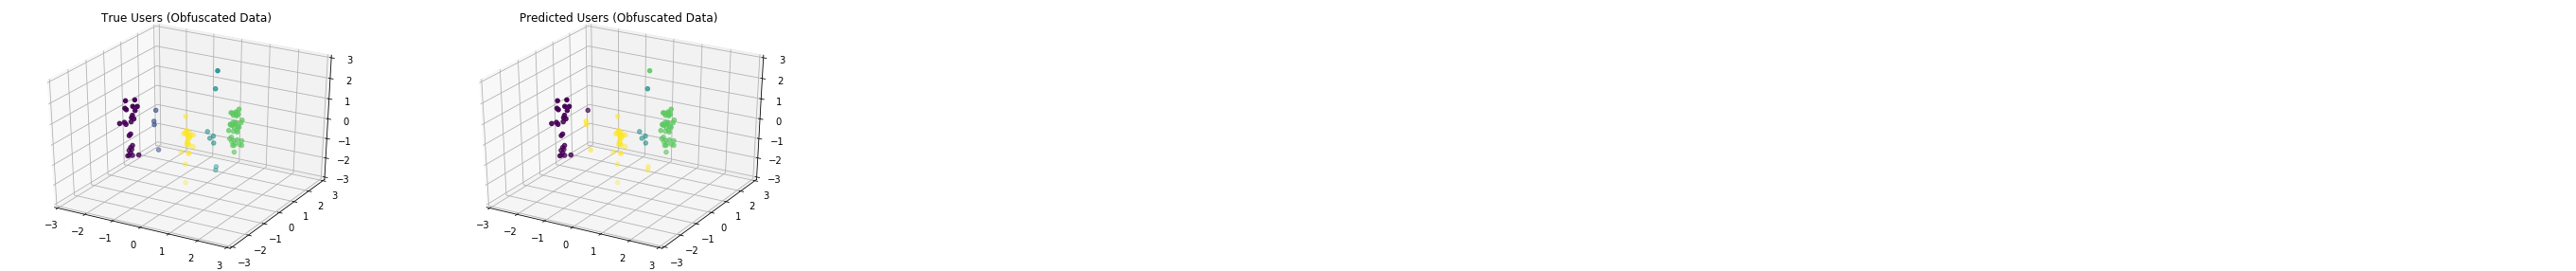

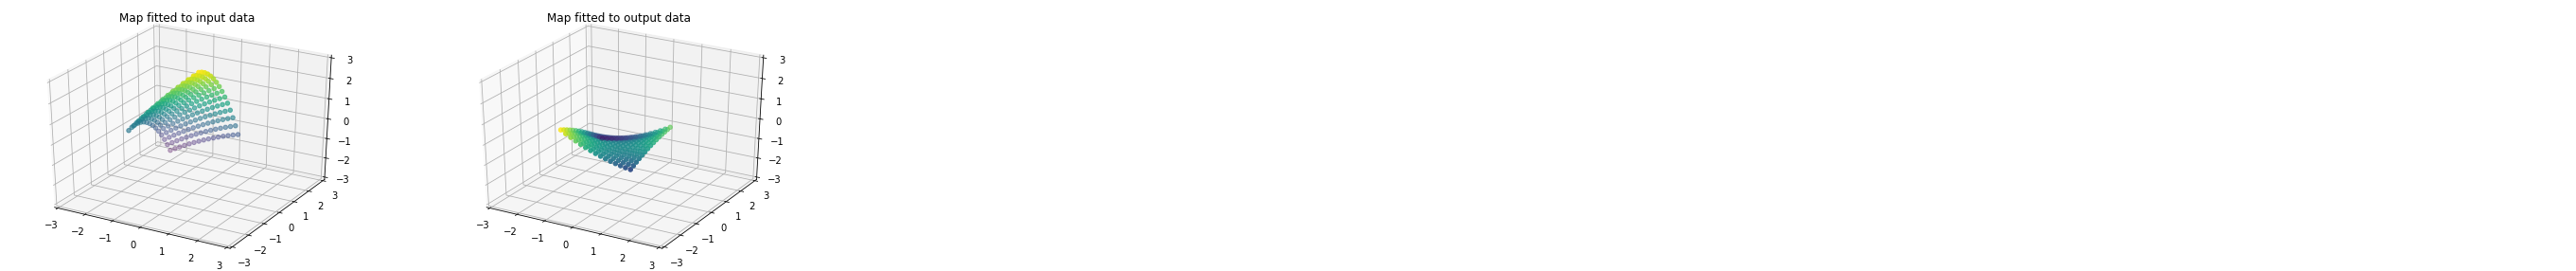

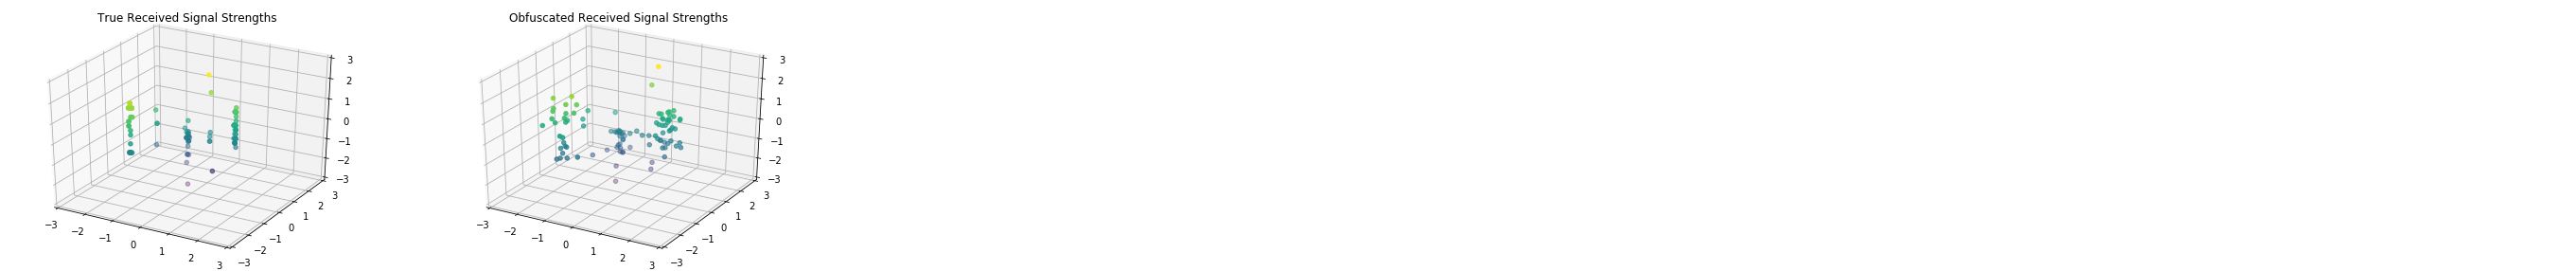

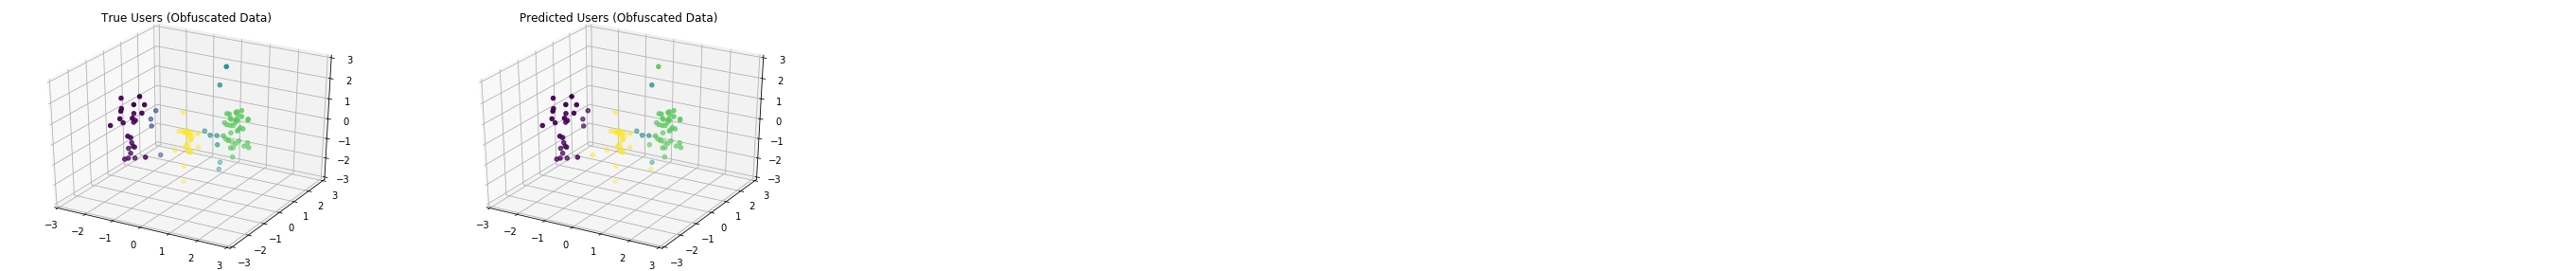

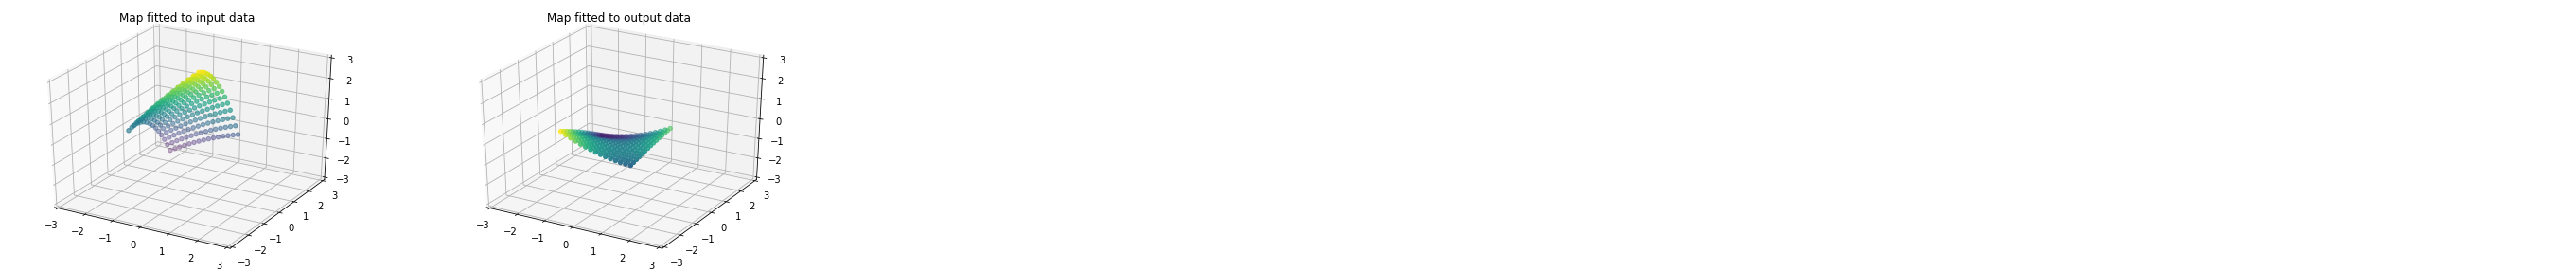

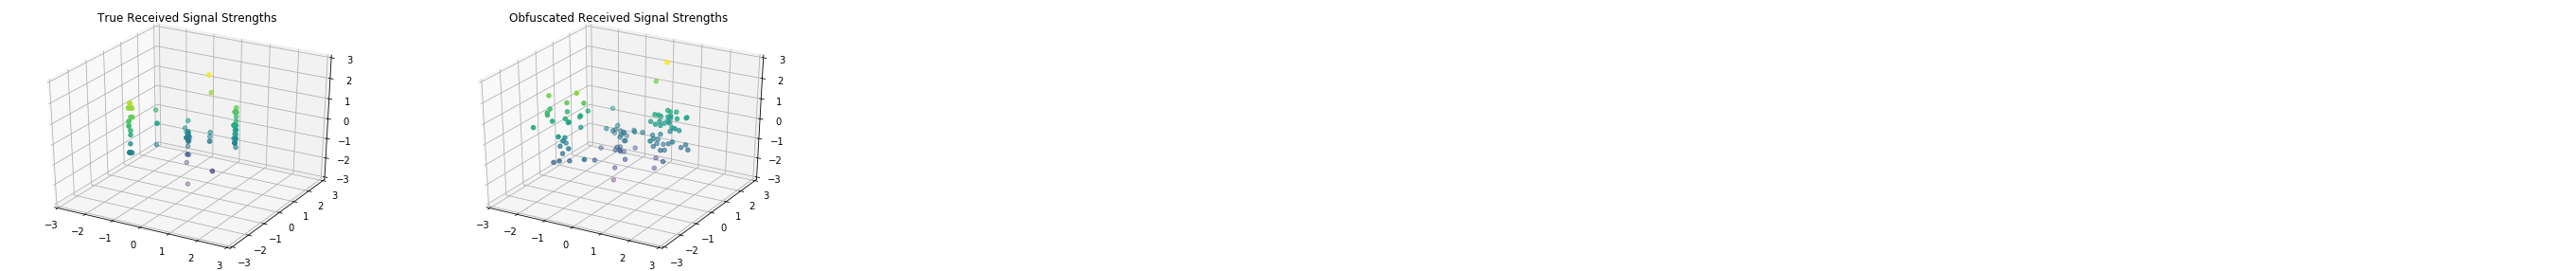

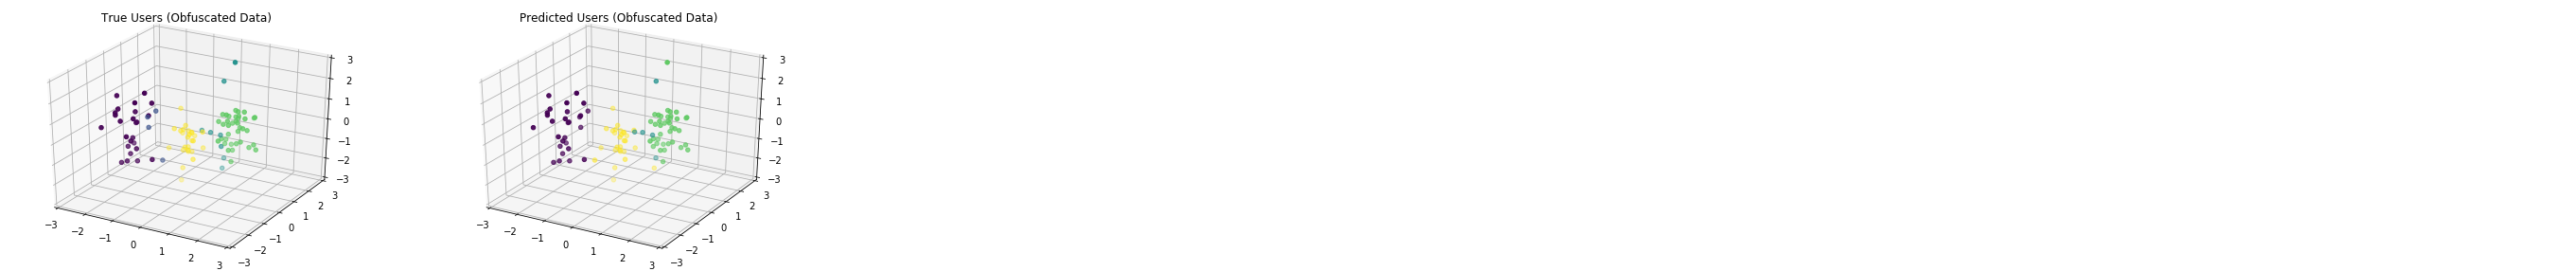

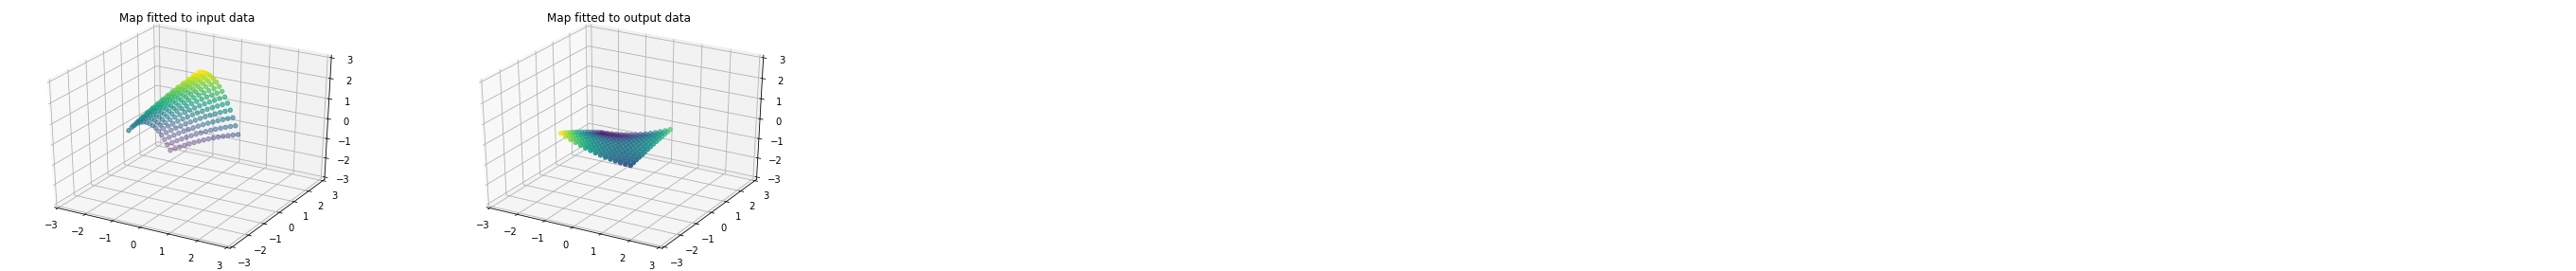

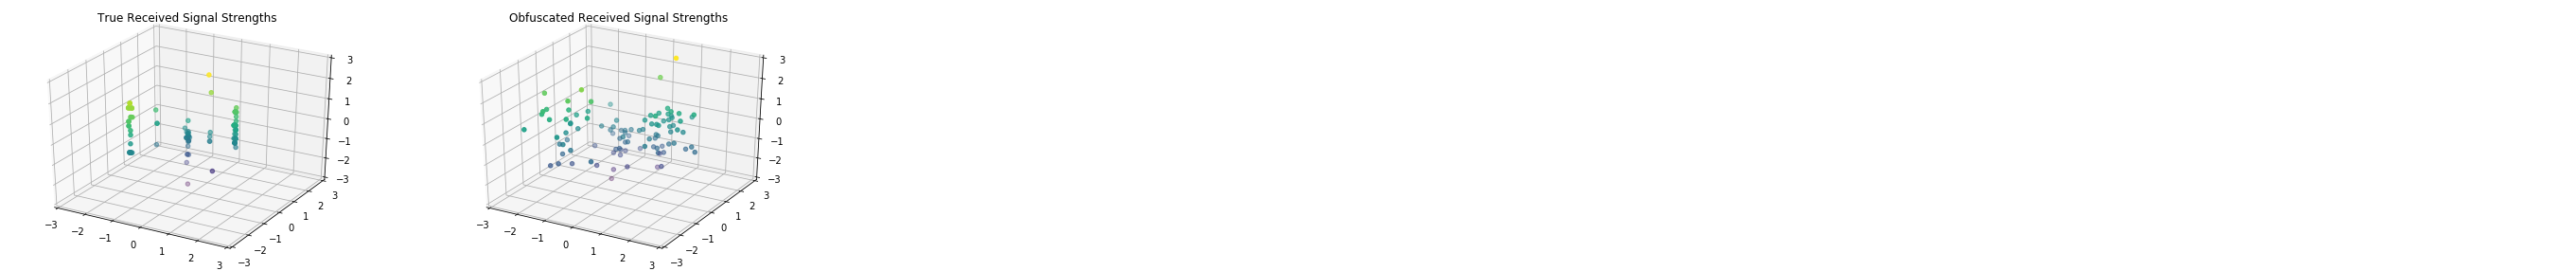

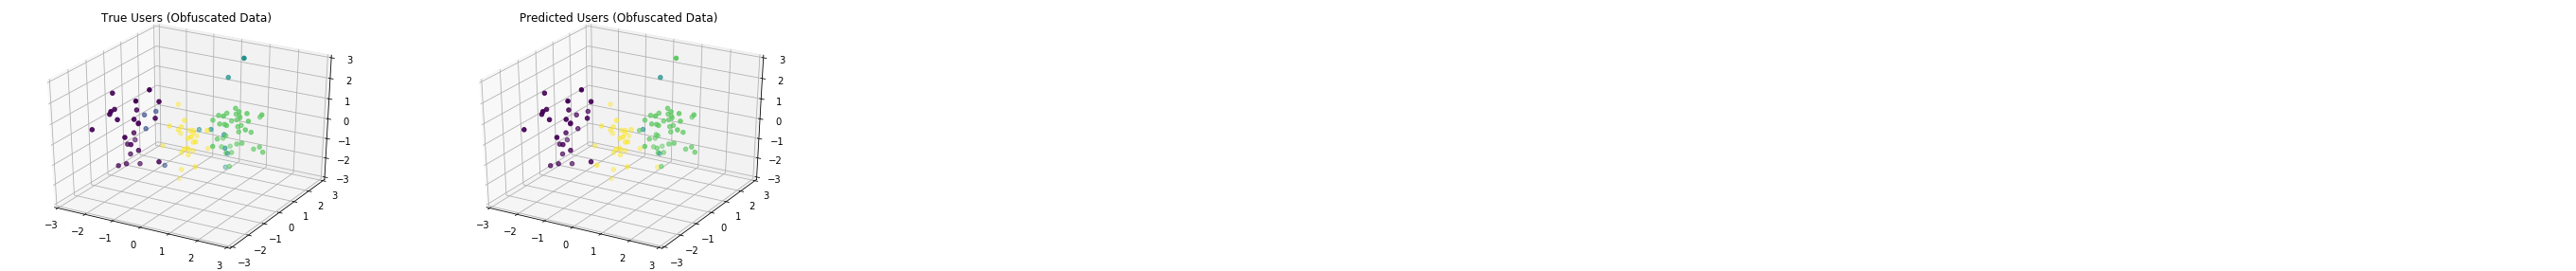

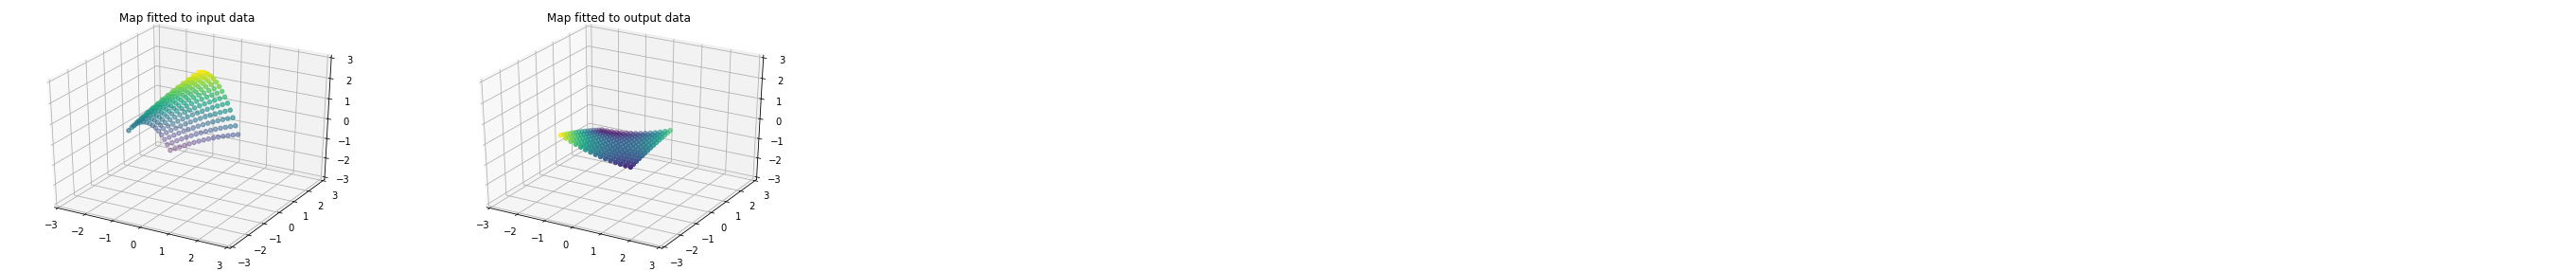

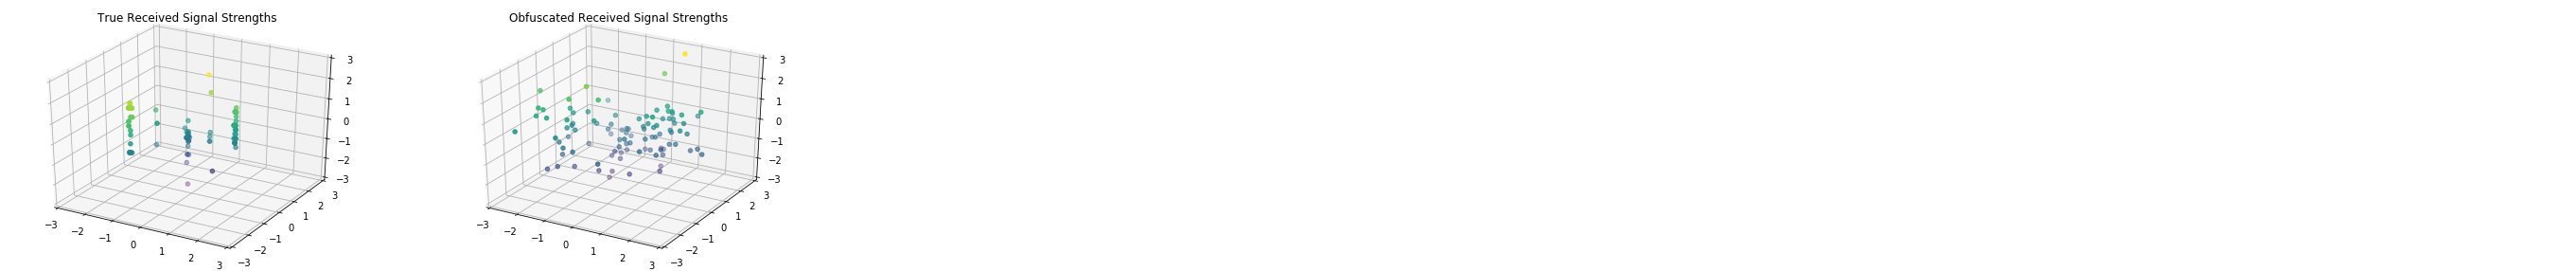

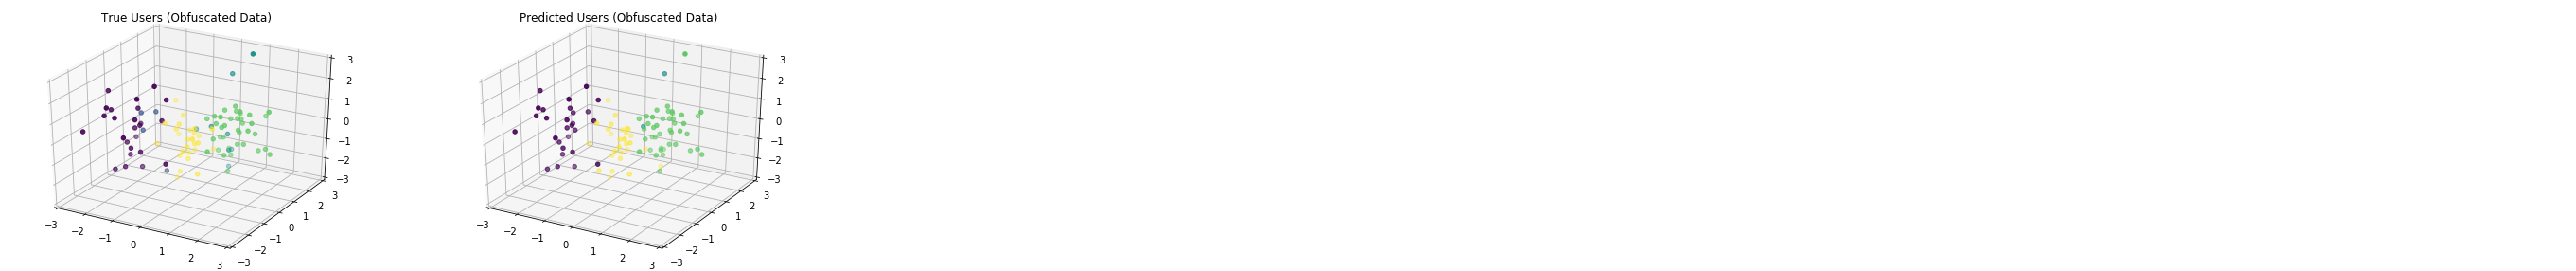

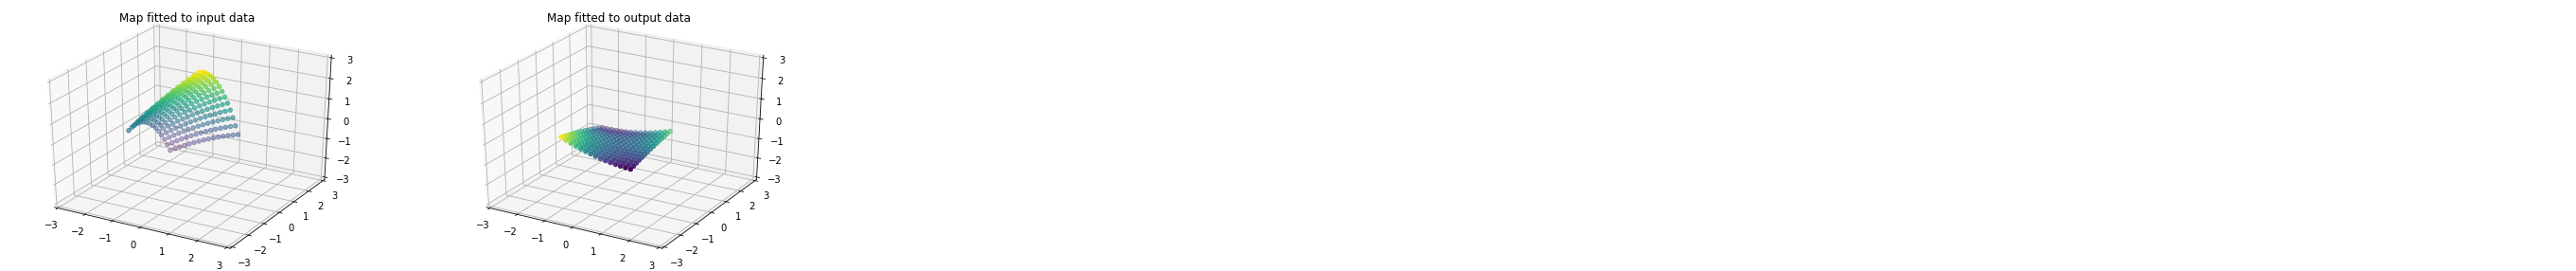

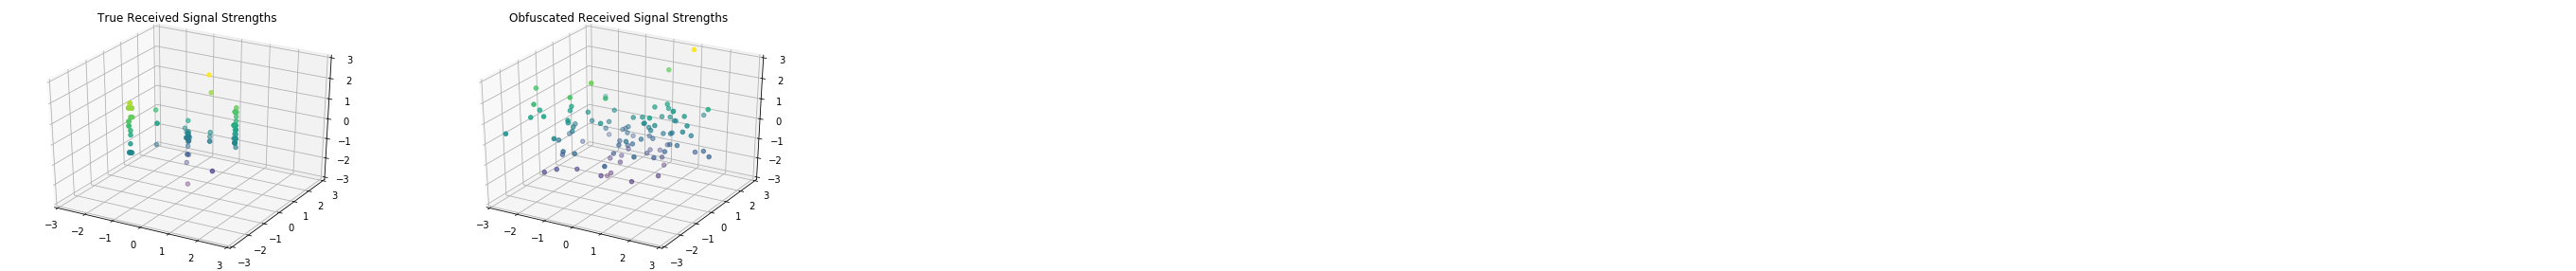

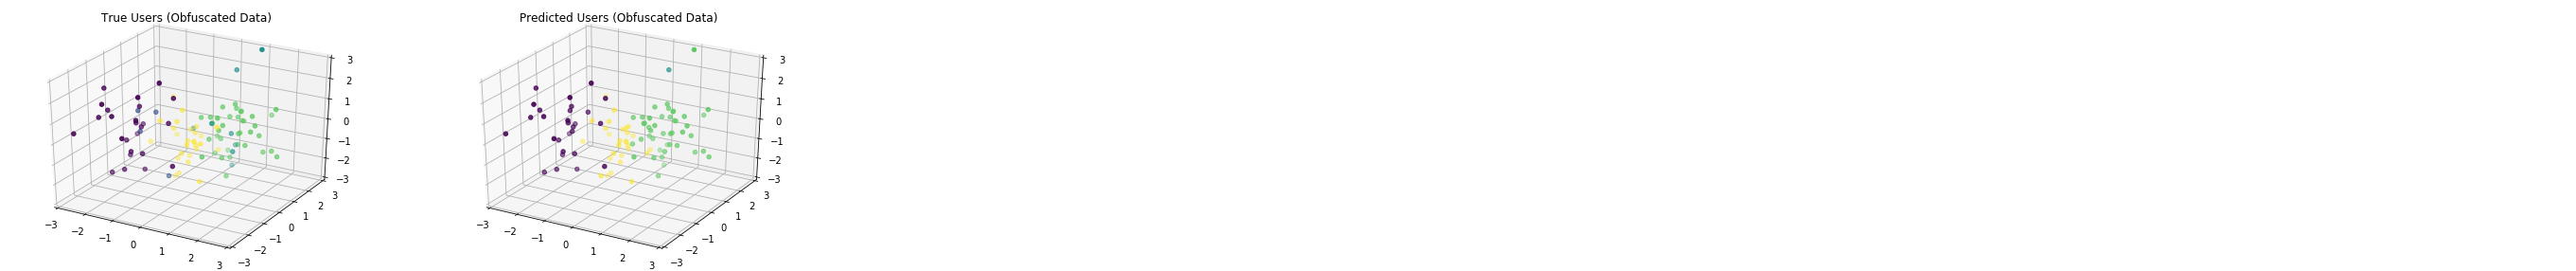

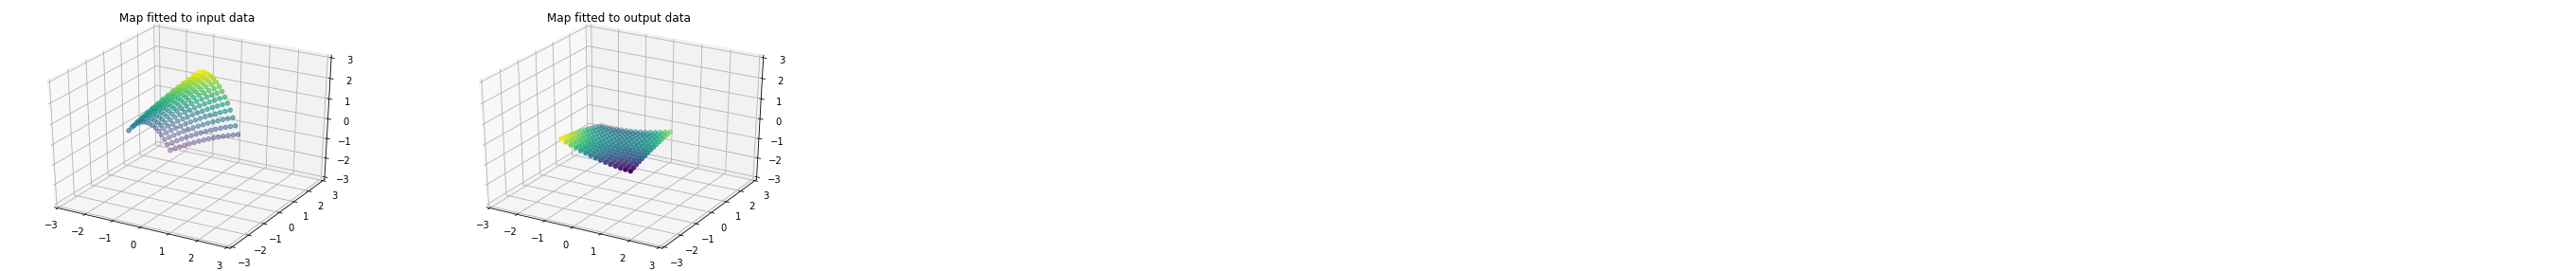

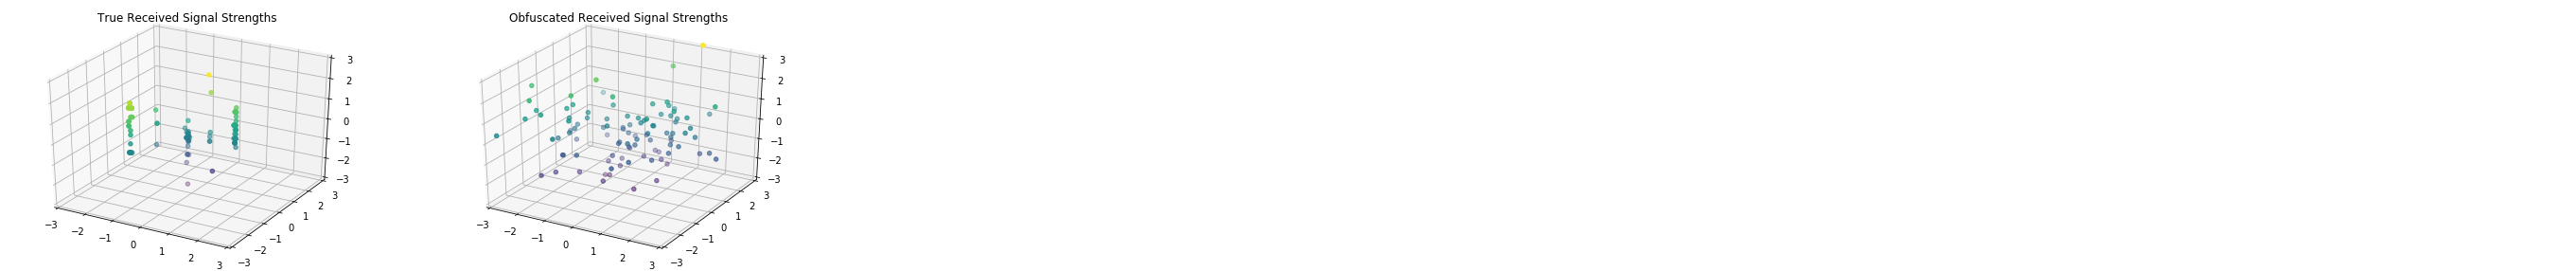

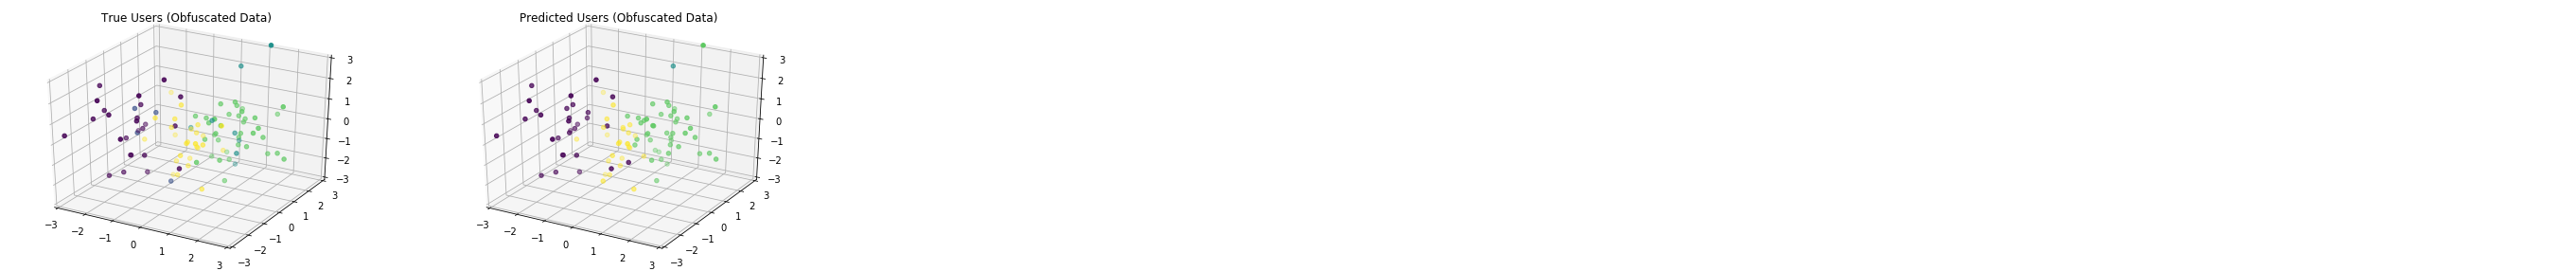

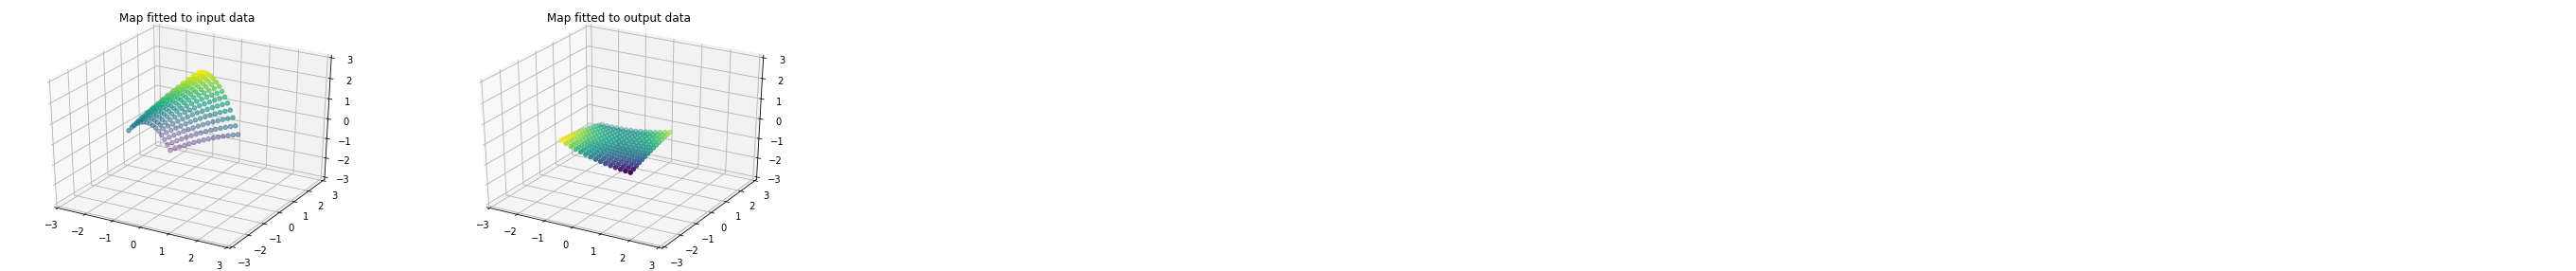

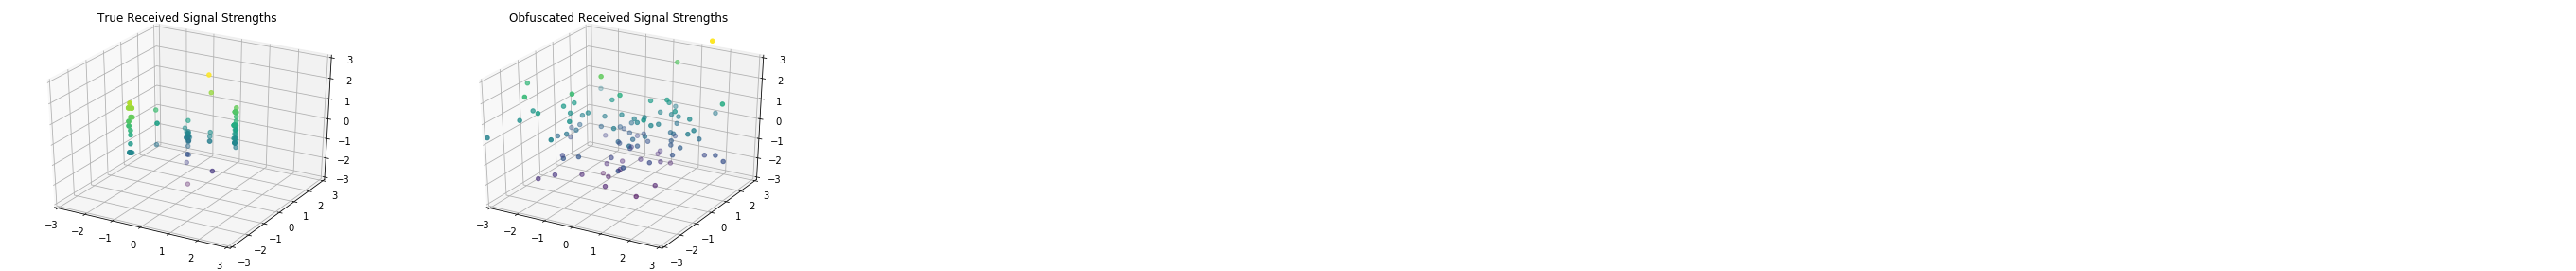

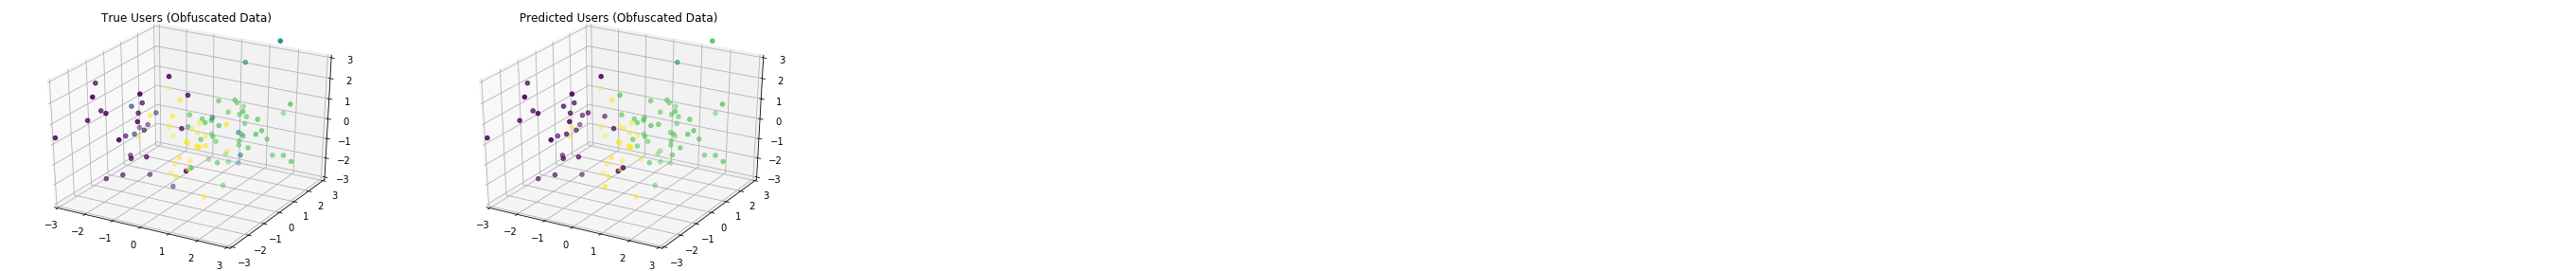

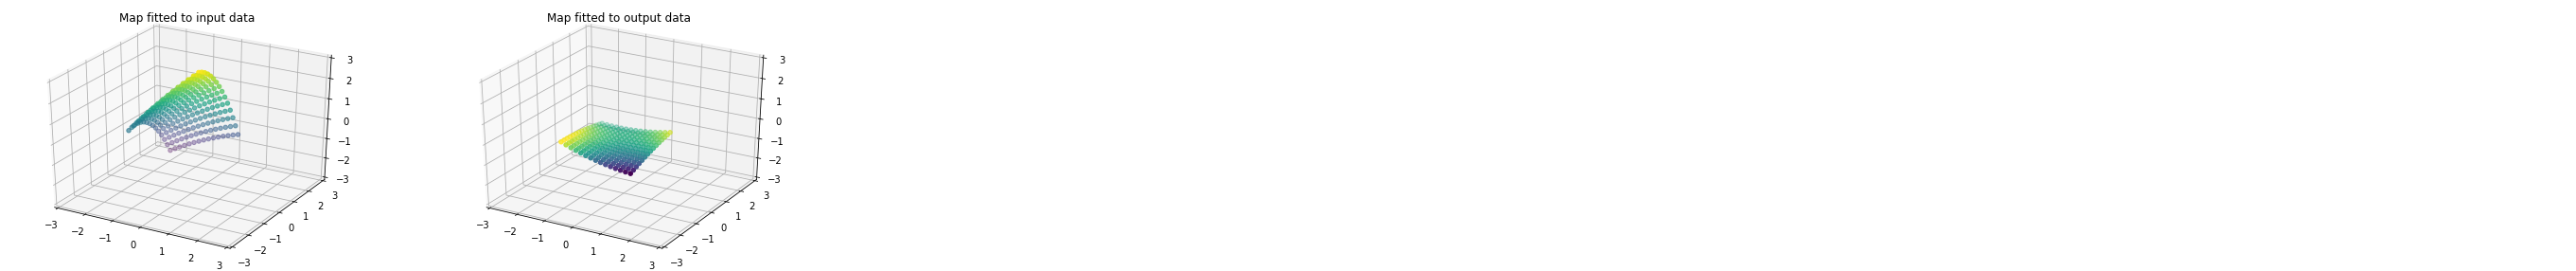

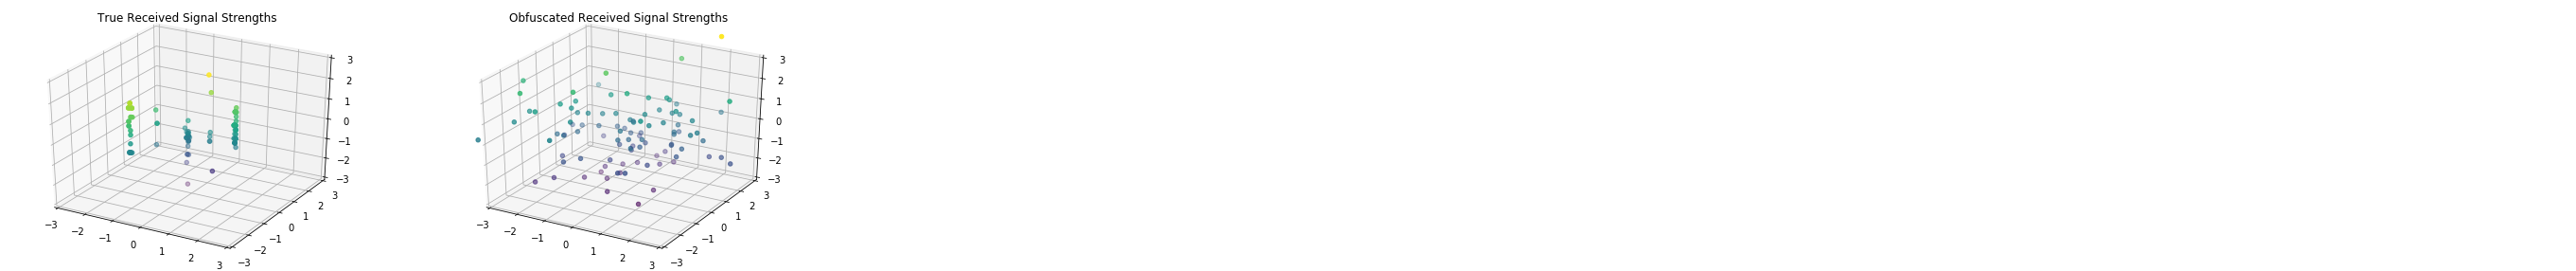

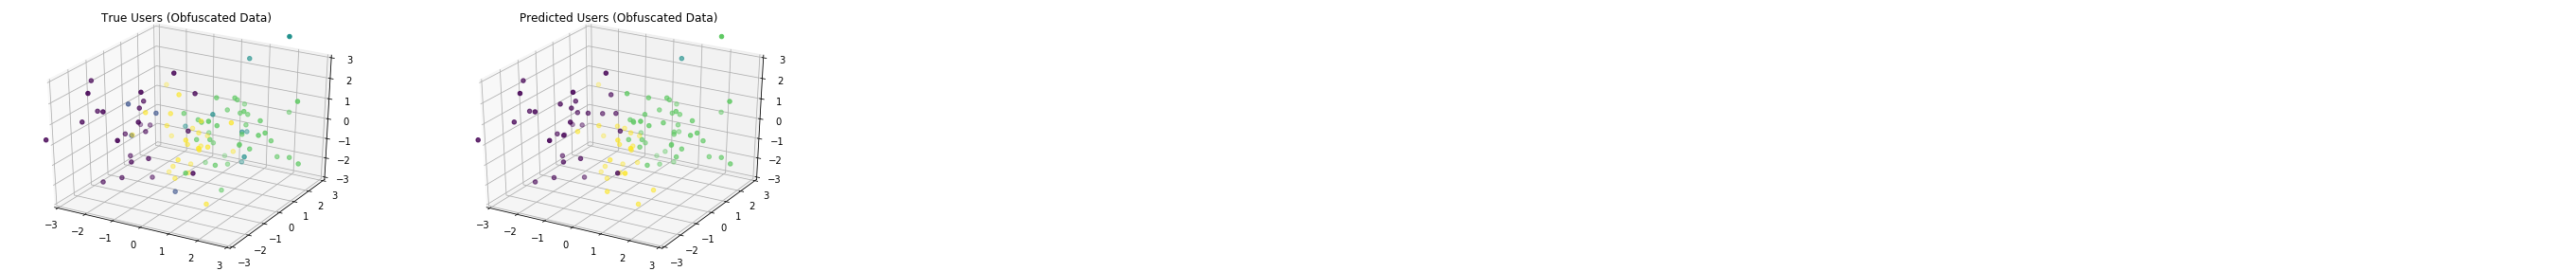

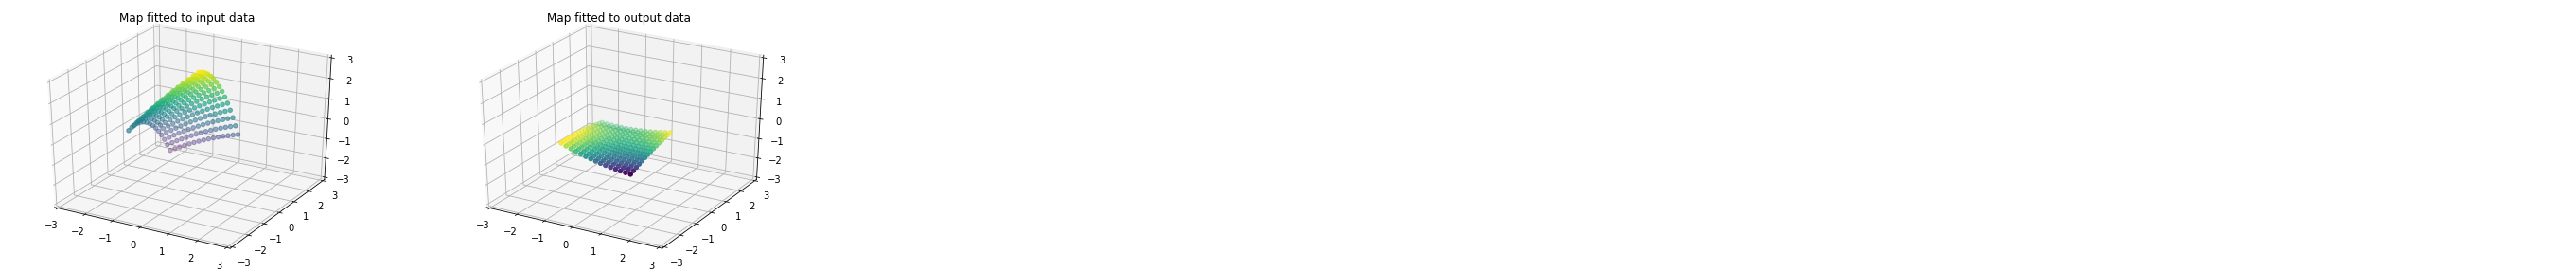

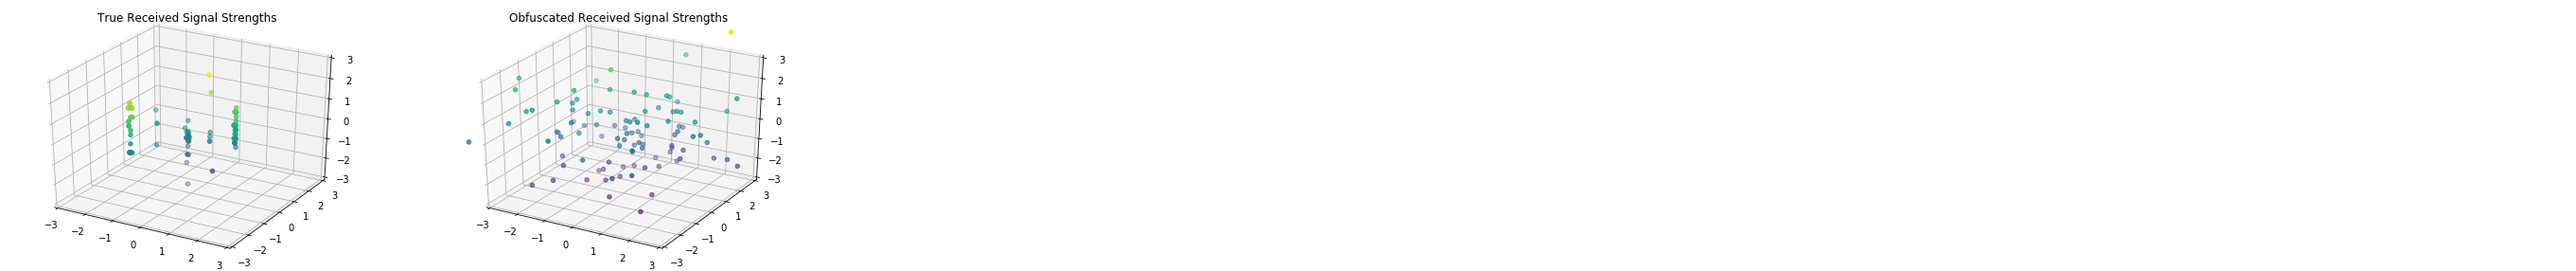

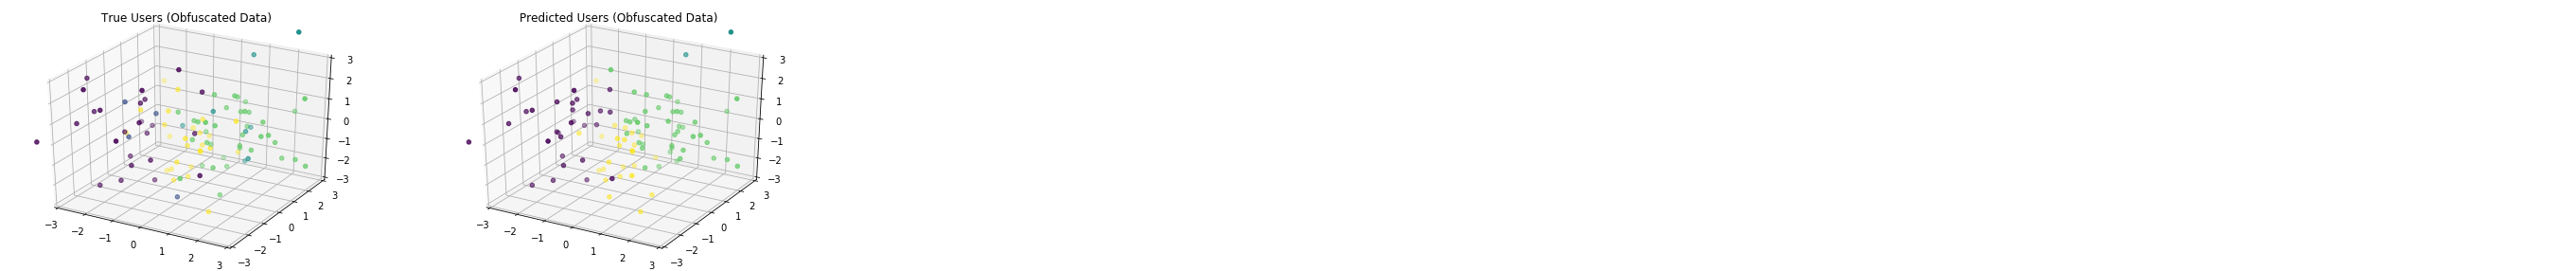

In [279]:
def run_SIMPLE_automation(show=False):
    
    def vis():
    
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], x.eval(session=sess)[:,1], c=x.eval(session=sess)[:,1])
        ax.set_title("True Received Signal Strengths")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=y.eval(session=sess)[:,1])
        ax1.set_title("Obfuscated Received Signal Strengths")
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 3)
        ax1.set_zlim(-3, 3)
        
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=trueusers.eval(session=sess))
        ax.set_title("True Users (Obfuscated Data)")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=np.argmax(users.eval(session=sess), axis=1))
        ax1.set_title("Predicted Users (Obfuscated Data)")
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 3)
        ax1.set_zlim(-3, 3)
        
    def makemap(grid, m1_coeffs, m2_coeffs):
        
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')
        
        vandermonde_grid = vandermonde(grid)

        rss1 = tf.matmul(vandermonde_grid, m1_coeffs)
        ax.scatter(grid.eval(session=sess)[:,1], grid.eval(session=sess)[:,0], rss1.eval(session=sess), c=rss1.eval(session=sess)[:,0])
        ax.set_title("Map fitted to input data")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        rss2 = tf.matmul(vandermonde_grid, m2_coeffs)
        ax1.scatter(grid.eval(session=sess)[:,1], grid.eval(session=sess)[:,0], rss2.eval(session=sess), c=rss2.eval(session=sess)[:,0])
        ax1.set_title("Map fitted to output data")
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 3)
        ax1.set_zlim(-3, 3)
        

    # call the standard deviation of the noise the penalty, for convenience
    PENALTY = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    I = 1
    all_data = np.empty((I*len(PENALTY),3))

    for P in range(len(PENALTY)):

        for i in range(I):

            sess = tf.Session()
            keras.backend.set_session(sess)
            
            npoints = 100

            x, trueusers = sampleChania(Chania, npoints, seed_val=0)

            yarray = x.eval(session=sess) + np.random.normal(scale=PENALTY[P], size=(npoints,4))
            y = tf.constant(yarray, tf.float32)

            map1_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            i1 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i2 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i3 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i4 = keras.layers.Dense(1, kernel_initializer=map1_init)
            m1 = i4(i3(i2(i1(x[:,2:]))))
            m1_target = tf.keras.backend.reshape(x[:,1], (npoints,1))
            m1_train = tf.train.GradientDescentOptimizer(0.01)
            m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]
            
            map2_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            o1 = keras.layers.Dense(4, kernel_initializer=map2_init)
            o2 = keras.layers.Dense(4, kernel_initializer=map2_init)
            o3 = keras.layers.Dense(4, kernel_initializer=map2_init)
            o4 = keras.layers.Dense(1, kernel_initializer=map2_init)
            m2 = o4(o3(o2(o1(y[:,2:]))))
            m2_target = tf.keras.backend.reshape(y[:,1], (npoints,1))
            m2_train = tf.train.GradientDescentOptimizer(0.01)
            m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

            a_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=3)
            a1 = keras.layers.Dense(7, kernel_initializer=a_init, activation=tf.nn.relu)
            a2 = keras.layers.Dense(5, kernel_initializer=a_init, activation=tf.nn.softmax)
            users = a2(a1(y))
            a_train = tf.train.GradientDescentOptimizer(0.01) # 0.01)
            a_vars = [a1.variables, a2.variables]

            x1min, x1max = np.min(x[:,2].eval(session=sess)), np.max(x[:,2].eval(session=sess))
            x2min, x2max = np.min(x[:,3].eval(session=sess)), np.max(x[:,3].eval(session=sess))
            testpoints = np.mgrid[x1min:x1max:15j, x2min:x2max:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)
            
            m1_loss = tf.reduce_mean(tf.square(m1_target - m1))
            m2_loss = tf.reduce_mean(tf.square(m2_target - m2))
            adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
            
            zero = tf.constant(0, dtype=tf.float32)
            penalty = tf.constant(PENALTY[P], dtype=tf.float32)
            threshold = tf.constant(0, dtype=tf.float32)     
            
            # UTILITY METRIC - discretized
            target_grid_rss = i4(i3(i2(i1(grid))))
            pred_grid_rss = o4(o3(o2(o1(grid))))
            map_error = tf.reduce_mean(tf.square(target_grid_rss - pred_grid_rss))
            
            # UTILITY METRIC 2 - first order
            stats_loss = tf.reduce_sum(tf.square(stats_matrix(x) - stats_matrix(y)))
            
            # UTILITY METRIC 3 - polynomial regression
            vandermonde_x = vandermonde(x[:,2:])
            m1_coeffs = tf.matmul(tf.linalg.inv(tf.matmul(tf.transpose(vandermonde_x), vandermonde_x)),
                                  tf.matmul(tf.transpose(vandermonde_x), tf.reshape(x[:,1],[100,1])))
            vandermonde_y = vandermonde(y[:,2:])       
            m2_coeffs = tf.matmul(tf.linalg.inv(tf.matmul(tf.transpose(vandermonde_y), vandermonde_y)),
                                  tf.matmul(tf.transpose(vandermonde_y), tf.reshape(y[:,1],[100,1])))
            approx_loss = tf.reduce_mean(tf.square(m2_coeffs - m1_coeffs))
            
            # PRIVATIZER LOSS
            utility_loss = tf.math.maximum(approx_loss, stats_loss)
            privatizer_loss = penalty*(utility_loss)-adversary_loss

            sess.run(tf.global_variables_initializer())
                       
            print("stats before:", stats_matrix(x).eval(session=sess))
            print("stats_loss:", stats_loss.eval(session=sess))
            print("learned parameters before:", m1_coeffs.eval(session=sess))
            print("approx_loss:", approx_loss.eval(session=sess))
#             m1_train_min = m1_train.minimize(m1_loss, var_list = m1_vars)
#             m1plot = train(m1_train_min, m1_loss, 10000, sess, True)
#             print("generated map error before:", map_error.eval(session=sess))

            a_train_min = a_train.minimize(adversary_loss, var_list = a_vars)
            aplot = train(a_train_min, adversary_loss, 10000, sess, True)
                
            print("stats after:", stats_matrix(y).eval(session=sess))
            print("stats_loss:", stats_loss.eval(session=sess))
            print("learned parameters after:", m2_coeffs.eval(session=sess))
            print("approx_loss:", approx_loss.eval(session=sess))
#             m2_train_min = m2_train.minimize(m2_loss, var_list = m2_vars)
#             m2plot = train(m2_train_min, m2_loss, 1000, sess, True)
#             print("generated map error after:", map_error.eval(session=sess))
                
            index = int(I*P+i)    
            all_data[index] = [PENALTY[P], utility_loss.eval(session=sess), adversary_loss.eval(session=sess)]

            print("Utility Loss:", utility_loss.eval(session=sess))
            print("Adversary Error:", adversary_loss.eval(session=sess))
            print("")
            
            tf.keras.backend.clear_session()
            
            makemap(grid, m1_coeffs, m2_coeffs)
        
            if show:
                vis()
    
    return all_data

simple_data = run_SIMPLE_automation(show=False)

In [174]:
def run_SIMPLE_automation(show=False):
    
    def vis():
    
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], x.eval(session=sess)[:,1], c=x.eval(session=sess)[:,1])
        ax.set_title("True Received Signal Strengths")
        ax.set_xlim(-3, 1)
        ax.set_ylim(-2, 1.5)
        ax.set_zlim(-3.5, 2.5)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=y.eval(session=sess)[:,1])
        ax1.set_title("Obfuscated Received Signal Strengths")
        ax1.set_xlim(-3, 1)
        ax1.set_ylim(-2, 1.5)
        ax1.set_zlim(-3.5, 2.5)
        
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=trueusers.eval(session=sess))
        ax.set_title("True Users (Obfuscated Data)")
        ax.set_xlim(-3, 1)
        ax.set_ylim(-2, 1.5)
        ax.set_zlim(-3.5, 2.5)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=np.argmax(users.eval(session=sess), axis=1))
        ax1.set_title("Predicted Users (Obfuscated Data)")
        ax1.set_xlim(-3, 1)
        ax1.set_ylim(-2, 1.5)
        ax1.set_zlim(-3.5, 2.5)

    NOISE = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,1.0]
    I = 1
    all_data = np.empty((I*len(NOISE),3))

    for N in range(len(NOISE)):

        for i in range(I):

            sess = tf.Session()
            keras.backend.set_session(sess)
            
            npoints = 500 #100
            x, trueusers = sampleChania(Chania, npoints, seed_val=0)

            yarray = x.eval(session=sess) + np.random.normal(scale=NOISE[N], size=(npoints,4))
            y = tf.constant(yarray, tf.float32)

            map1_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            i1 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i2 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i3 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i4 = keras.layers.Dense(1, kernel_initializer=map1_init)
            m1 = i4(i3(i2(i1(x[:,2:]))))
            m1_target = tf.keras.backend.reshape(x[:,1], (npoints,1))
            m1_train = tf.train.GradientDescentOptimizer(0.01)
            m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]
            
            map2_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            o1 = keras.layers.Dense(4, kernel_initializer=map1_init)
            o2 = keras.layers.Dense(4, kernel_initializer=map1_init)
            o3 = keras.layers.Dense(4, kernel_initializer=map1_init)
            o4 = keras.layers.Dense(1, kernel_initializer=map1_init)
            m2 = o4(o3(o2(o1(y[:,2:]))))
            m2_target = tf.keras.backend.reshape(y[:,1], (npoints,1))
            m2_train = tf.train.GradientDescentOptimizer(0.01)
            m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

            a_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=3)
            a1 = keras.layers.Dense(7, kernel_initializer=a_init, activation=tf.nn.relu)
            a2 = keras.layers.Dense(5, kernel_initializer=a_init, activation=tf.nn.softmax)
            users = a2(a1(y))
            a_train = tf.train.GradientDescentOptimizer(0.01) # TODO
            test_a_train = tf.train.GradientDescentOptimizer(0.01) # TODO
            a_vars = [a1.variables, a2.variables]

            m1_loss = tf.placeholder(tf.float32)
            adversary_loss = tf.placeholder(tf.float32)
            map_error = tf.placeholder(tf.float32)
            x1min, x1max = np.min(x[:,2].eval(session=sess)), np.max(x[:,2].eval(session=sess))
            x2min, x2max = np.min(x[:,3].eval(session=sess)), np.max(x[:,3].eval(session=sess))
            testpoints = np.mgrid[x1min:x1max:15j, x2min:x2max:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)
            sess.run(tf.global_variables_initializer())
            
            m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1_target, m1))
            m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)
            
            m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2_target, m2))
            m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)
            
            adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
            a_train = a_train.minimize(adversary_loss, var_list = a_vars)
            
            target_grid_rss = i4(i3(i2(i1(grid))))
            pred_grid_rss = o4(o3(o2(o1(grid))))
            map_error = tf.reduce_mean(tf.keras.losses.mean_squared_error(target_grid_rss, pred_grid_rss))
            
            m1plot = train(m1_train, m1_loss, 10000, sess, True)
            m2plot = train(m2_train, m2_loss, 10000, sess, True)
            aplot = train(a_train, adversary_loss, 10000, sess, True)                
            index = int(I*N+i)
            
            print("Map Error:", map_error.eval(session=sess))
            print("Adversary Error:", adversary_loss.eval(session=sess))
            
            all_data[index] = [NOISE[N], map_error.eval(session=sess), adversary_loss.eval(session=sess)]
            tf.keras.backend.clear_session()
        
            if show:
                vis()
    
    return all_data
            
simple_data = run_SIMPLE_automation(show=False)

Map Error: 0.0
Adversary Error: 0.19591826
Map Error: 0.0009045721
Adversary Error: 0.19220099
Map Error: 0.008494275
Adversary Error: 0.20861518
Map Error: 0.021468189
Adversary Error: 0.25560006
Map Error: 0.02979669
Adversary Error: 0.31562325
Map Error: 0.035990342
Adversary Error: 0.3912942
Map Error: 0.038577303
Adversary Error: 0.48045224
Map Error: 0.040119596
Adversary Error: 0.57131606
Map Error: 0.04224966
Adversary Error: 0.6531956
Map Error: 0.04468238
Adversary Error: 0.73688626
Map Error: 0.046350475
Adversary Error: 0.8003868


In [280]:
simple_data

array([[0.1       , 0.87573713, 0.24946235],
       [0.2       , 0.89131385, 0.22691141],
       [0.3       , 0.90979213, 0.26054066],
       [0.4       , 0.93571514, 0.30835795],
       [0.5       , 0.96416718, 0.37362862],
       [0.6       , 0.99124694, 0.44527808],
       [0.7       , 1.01479042, 0.54571968],
       [0.8       , 1.03412092, 0.6402331 ],
       [0.9       , 1.04945934, 0.73060721],
       [1.        , 1.06141841, 0.79934496]])

In [281]:
# SIMPLE_data = simple_data
SIMPLE_data = np.append(SIMPLE_data, simple_data, axis=0)

In [282]:
# SIMPLE_data = SIMPLE_data[np.where(SIMPLE_data[:,0]!=2.0)]

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

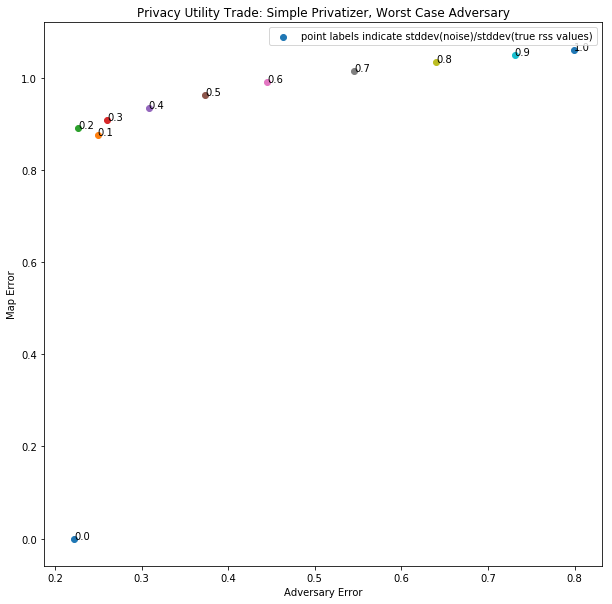

In [283]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(SIMPLE_data[:,0]):
    indices = np.where(SIMPLE_data[:,0]==i)
    plt.scatter(np.mean(SIMPLE_data[indices][:,2]), np.mean(SIMPLE_data[indices][:,1]))
    plt.text(np.mean(SIMPLE_data[indices][:,2]), np.mean(SIMPLE_data[indices][:,1]), str(SIMPLE_data[indices][0][0]))
plt.legend(["point labels indicate stddev(noise)/stddev(true rss values)"], loc="best")
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")